In [2]:
import numpy as np
from matplotlib import pyplot as plt
import io

In [3]:
def square(patterns):
    x = np.sin(patterns)
    return np.where(x>=0,1,-1)

def generate_data(is_sin):
    training_patterns = np.arange(0,2*np.pi,0.1)
    
    test_patterns = np.arange(0,2*np.pi,0.05)
    

    if is_sin:
        training_targets = np.sin(2*training_patterns)
        test_targets = np.sin(2*test_patterns)
        i = np.arange(training_patterns.shape[0])
        np.random.shuffle(i)
        training_patterns=training_patterns[i]
        training_targets=training_targets[i]

        i = np.arange(test_patterns.shape[0])
        np.random.shuffle(i)
        test_patterns=test_patterns[i]
        test_targets=test_targets[i]
        return training_patterns, training_targets , test_patterns, test_targets
    
    else:
        training_targets = square(training_patterns)
        test_targets = square(test_patterns)
        i = np.arange(training_patterns.shape[0])
        np.random.shuffle(i)
        training_patterns=training_patterns[i]
        training_targets=training_targets[i]

        i = np.arange(test_patterns.shape[0])
        np.random.shuffle(i)
        test_patterns=test_patterns[i]
        test_targets=test_targets[i]
        return training_patterns, training_targets, test_patterns, test_targets


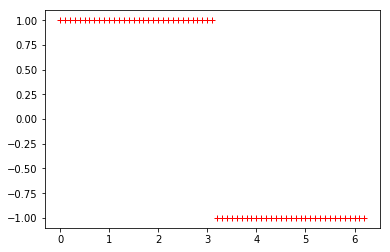

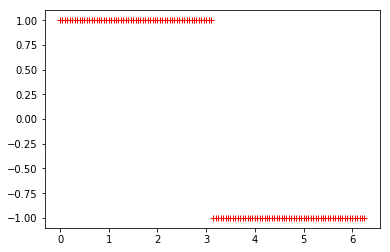

In [4]:
training_patterns, training_targets, test_patterns, test_targets = generate_data(0)
plt.plot(training_patterns,training_targets, 'r+')
plt.figure()
plt.plot(test_patterns,test_targets,'r+')

In [175]:
def evenly_spaced_rbf(n):
    mu_s = np.zeros((n,1))
    for i in range(n):
        mu_s[i] = i*2*np.pi/n
    return mu_s

def random_rbf(n):
    mu_s = np.zeros((n,1))
    for i in range(n):
        mu_s[i] = (2*np.random.random_sample()*np.pi)
    
    return mu_s

def competetive_rbf(n,x_s,iterations,eta,n_winners):
    mu_s = np.zeros((n,1))
    for i in range(n):
        mu_s[i] = 2*np.pi*np.random.random_sample()
    random_mu_s = mu_s
    #plt.scatter(mu_s,np.sin(2*mu_s), c='b', label="Before")
    plt.scatter(mu_s,np.sin(2*mu_s), c='b', label="Before")
    #print(mu_s)
    #mu_s = mu_s/np.linalg.norm(mu_s)
    #mu_s = mu_s*2*np.pi
    #print(iterations)
    for i in range(iterations):
        train_vec = x_s[np.random.randint(0,x_s.shape[0])]
        distances = np.empty((0,0))
        for mu in mu_s:
            distances = np.append(distances,(np.linalg.norm(train_vec-mu)))
        
        ind = np.argpartition(distances, -n_winners)[-n_winners:]
        
        #print(abs(train_vec-closest_mu))
        #print(i)
        for k in ind:
            mu_s[k] = mu_s[k]+eta*(train_vec[k]-mu[k])
        #mu_s = mu_s/np.linalg.norm(mu_s)
        #mu_s = mu_s*2*np.pi
    plt.figure()
    
    plt.scatter(mu_s,np.sin(2*mu_s), c='r', label="After")
    return mu_s, random_mu_s


def competetive_rbf2(n,x_s,iterations,eta,radius):
    mu_s = np.zeros((n,1))
    for i in range(n):
        mu_s[i] = 2*np.pi*np.random.random_sample()
    
    #mu_s = evenly_spaced_rbf(n)
    random_mu_s = np.copy(mu_s)
    #plt.scatter(mu_s,np.sin(2*mu_s), c='b', label="Before")
    plt.scatter(mu_s,np.sin(2*mu_s), c='b', label="Before")
    #print(mu_s)
    #mu_s = mu_s/np.linalg.norm(mu_s)
    #mu_s = mu_s*2*np.pi
    #print(iterations)
    for i in range(iterations):
        train_vec = x_s[np.random.randint(0,x_s.shape[0])]
        distances = np.empty((0,0))
        for mu in mu_s:
            distances = np.append(distances,(np.linalg.norm(train_vec-mu)))
        
        index = np.argmin(distances)
        winner = mu_s[index]
                
        for k,mu in enumerate(mu_s):
            mu_distance = np.linalg.norm(mu-winner)
            
            if mu_distance <= radius:
        
                mu_s[k] = mu+eta*(train_vec-mu_s[k])
        #print(ind)
        #print(distances)
        #print(abs(train_vec-closest_mu))
        #print(i)
        #mu_s = mu_s/np.linalg.norm(mu_s)
        #mu_s = mu_s*2*np.pi
        
    plt.figure()
    
    plt.scatter(mu_s,np.sin(2*mu_s), c='r', label="After")
    return mu_s, random_mu_s

def competetive_rbf_2D(n,x_s,iterations,eta,radius):
    #mu_s = np.copy(x_s[:,0:n])
    mu_s = np.amax(x_s)*np.random.random_sample((x_s.shape[0],n)) -np.absolute(np.amin(x_s))
    
    random_mu_s = mu_s
    #plt.scatter(mu_s,np.sin(2*mu_s), c='b', label="Before")
    #plt.figure()
    plt.scatter(mu_s[0,:],mu_s[1,:], c='b', label="Before")
    #print("mushape",mu_s.shape)
    #mu_s = mu_s/np.linalg.norm(mu_s)
    #mu_s = mu_s*2*np.pi
    #print(iterations)
    #train_vectors = np.empty((0,0))
    for i in range(iterations):
        #print(x_s[:,np.random.randint(0,x_s.shape[1])])
        train_vec = x_s[:,np.random.randint(0,x_s.shape[1])]
        train_vectors = np.empty((2,0))
        distances = np.empty((0,0))
        for j in range(mu_s.shape[1]):
            #print(mu_s[:,j].shape)
            #print(train_vec.shape)
            #train_vec = train_vec.reshape((-1,1))
            #print(train_vec.shape)
            #print(train_vectors.shape)
            #print(distances.shape)
            distances = np.append(distances,(np.linalg.norm(train_vec-mu_s[:,j])))
            #train_vectors = np.append(train_vectors,train_vec,axis=1)
        #ind = np.argpartition(distances, -n_winners)[-n_winners:]
        
        #print(abs(train_vec-closest_mu))
        #print(i)
        
        index = np.argmin(distances)
        winner = mu_s[:,index]
        #print(mu_s)
        #print("elements")
        for k,mu in enumerate(mu_s.T):
            mu_distance = np.linalg.norm(mu-winner)
            
            if mu_distance <= radius:
                #print(mu.shape)
                #print(train_vec.shape)
                #print(mu)
                #print(mu_s[:,k].shape)
                mu_s[:,k] = mu_s[:,k]+eta*(train_vec-mu_s[:,k])
        #for k in ind:
            #print(train_vectors.shape)
            #print(mu_s.shape)
            
            #mu_s[:,k] = mu_s[:,k]+eta*(train_vectors[:,k]-mu_s[:,k])
        #mu_s = mu_s/np.linalg.norm(mu_s)
        #mu_s = mu_s*2*np.pi
    #plt.figure()
    
    plt.scatter(mu_s[0,:],mu_s[1,:], marker='+', c='r', label="After")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Datapoints','Before CL', 'After CL'])
    plt.savefig("3.3.3_before_after.png")
    return mu_s, random_mu_s


In [176]:
def calculate_mse(f_hat,f):
    return np.mean((f_hat-f)**2)

def calculate_NMAE(f_hat,f):
    return np.mean(np.abs(f_hat-f))

def gaussian(x, mu, sigma):
    #print(np.exp(-(x-mu)**2/(2*sigma**2)).shape)
    return np.exp(-(np.linalg.norm(x-mu))**2/(2*sigma**2))

    
def get_phi(x_s, mu_s,sigma):
    #print(x_s.shape)
    phi_s = np.zeros((x_s.shape[0],mu_s.shape[0]))
    #print(phi_s.shape)
    for i, mu in enumerate( mu_s):
        for j,  x in enumerate( x_s):
            phi_s[j,i]=gaussian(mu,x,sigma)
    return phi_s

def get_phi_seq(x_s, mu_s,sigma):
    #print(x_s.shape)
    phi_s = np.zeros(mu_s.shape[1])
    #print(phi_s.shape)
    for i, mu in enumerate(mu_s.T):
        #print(i)
        phi_s[i]=gaussian(mu,x_s,sigma)
    return phi_s

def train_network_batch(x_s,f,mu_s,sigma):

    phi_s = get_phi(x_s,mu_s,sigma)
    #print(phi_s.shape)
    #print(phi_s)
    #dim phi_s(Nxn) dim weight(nx1)
    
    w = np.matmul(np.matmul(phi_s.T,f),np.linalg.inv(np.matmul(phi_s.T,phi_s)))
    f_hat = np.sum(np.multiply(phi_s,w),axis=1)
    mse = calculate_mse(f_hat,f)
    return w, mse

def train_network_delta_rule(x_s,f,mu_s,sigma,eta, epochs):
    """
    w=np.random.randn(mu_s.shape[0],1)
    
    for epoch in range(epochs):

        f_hat = np.zeros(f.shape[0])
        for k,x in enumerate(x_s):
            phi_s_x_k = np.zeros((mu_s.shape[0],1))
            for n,mu in enumerate(mu_s):
                phi_s_x_k[n] = gaussian(x,mu,sigma)
            #print(phi_s_x_k.shape)
            #print(w.shape)
            f_hat[k] = np.dot(phi_s_x_k.T,w)
            e = (f[k] - f_hat[k])**2
            delta_w = eta*e*phi_s_x_k
            w = w + delta_w
    """
    learning_error_list= np.zeros(epochs)
    W=np.random.randn(mu_s.shape[1],2)
    
    for i in range(epochs):
        e_list=[]
        x = np.zeros((2,1))
        for k in range(np.shape(x_s)[1]):
            x[:,0] = x_s[:,k]
            #print(x.shape)
            phi = get_phi_seq(x,mu_s,sigma)
            #print(phi.shape)
            phi = phi.reshape(1,-1)
            #print(phi.shape)
            #print(W.shape)
            #print(np.matmul(phi,W).T.shape)
            #print(f[:,k].reshape((2,1)).shape)
            e=f[:,k].reshape((2,1))-np.matmul(phi,W).T
            error=np.sqrt(e**2)
            e_list.append(error)
            #print(e.shape)
            #print(mu_s.shape)
            #print(phi.shape)
            #print(phi.reshape(mu_s.shape[1],2).shape)
            W=W+eta*(e*phi).T

        learning_error=np.mean(e_list)
        learning_error_list[i] = learning_error
    
    #return w,calculate_mse(f,f_hat)
    return W, np.mean(learning_error_list)
    
    
    return w, np.mean(tmp)
def predict(x_s,mu_s,sigma,w):
    x = np.zeros((2,1))
    f_hats = np.zeros((2,x_s.shape[1]))
    #print(x_s.shape)
    for k in range(np.shape(x_s)[1]):
        x[:,0] = x_s[:,k]
        #print(x.shape)
        phi_s = get_phi_seq(x,mu_s,sigma)
        #print(phi_s.shape)
        #print(w.shape)
        phi_s = phi_s.reshape(1,-1)
        #print(np.matmul(phi_s,w).shape)
        f_hat = np.matmul(phi_s,w).T
        #print(f_hat.shape)
        #print(f_hats.shape)
        f_hats[:,k] = f_hat.T
    return f_hats




(100, 2)
(2, 100)
(2, 100)
(2, 100)
NMAE seq: 0.07263112193148419
NMAE test: 0.08911010745007623
(2, 100)
NMAE seq: 0.07452646942263427
NMAE test: 0.0917500025802868


'\n#mu_s = evenly_spaced_rbf(num_of_rbf)\n#print(mu_s)\nmu_s, random_mu_s = competetive_rbf(num_of_rbf,training_patterns,20,eta,1)\n#print(mu_s)\n\n#mu_s = competetive_rbf(num_of_rbf,training_patterns,100,eta)\n#print(mu_s)\n#mu_s = unevenly_spaced_rbf(num_of_rbf)\n#print(mu_s)\nprint(training_patterns.shape)\nw,mse = train_network_batch(training_patterns, training_targets,mu_s,sigma)\nprint("MSE:", mse)\nf_hat = predict(test_patterns,mu_s,sigma,w)\nmse_test = calculate_mse(f_hat,test_targets)\nprint("MSE test:",mse_test)\n#plt.figure()\nplt.plot(test_patterns,f_hat,\'+\')\n\nw, mse = train_network_delta_rule(training_patterns, training_targets,mu_s,sigma,eta,epochs)\nprint("MSE seq:", mse)\n'

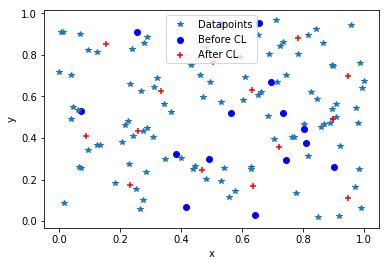

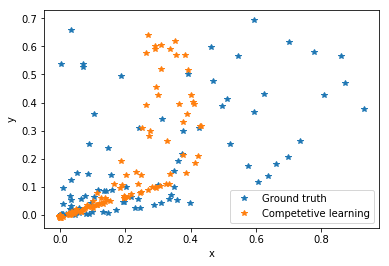

In [177]:
noise = True

sigma = 0.4
num_of_rbf = 15
eta = 1e-2
eta_rbf = 1e-1
epochs = 1000

data = open("data_lab2/ballist.dat").read().replace('\t',' ')
ballistic_data = np.loadtxt(io.StringIO(data),skiprows=0, delimiter=" ")

data2 = open("data_lab2/balltest.dat").read().replace('\t',' ')
balltest_data = np.loadtxt(io.StringIO(data2), delimiter=" ", skiprows=0)

train_X = ballistic_data[:,0:2]
train_Y = ballistic_data[:,2:4]
test_X = balltest_data[:,0:2]
test_Y = balltest_data[:,2:4]
plt.figure()


train_X = train_X.T
plt.plot(train_X[0,:],train_X[1,:],'*')
print(train_Y.shape)
train_Y = train_Y.T
print(train_Y.shape)
print(train_X.shape)
test_X = test_X.T
test_Y = test_Y.T
print(test_Y.shape)
#mu_s = evenly_spaced_rbf(num_of_rbf)
#print(mu_s)
#mu_s = random_rbf(num_of_rbf)
#print(mu_s)
#x = np.vstack((training_patterns,training_targets))
#print(x.shape)
mu_s, random_mu_s = competetive_rbf_2D(num_of_rbf,train_X,1000,eta_rbf,0.1)

#print(mu_s)
#mu_s = unevenly_spaced_rbf(num_of_rbf)
#print(mu_s)
#print(training_patterns.shape)
#w,mse = train_network_batch(train_X, train_Y,random_mu_s,sigma)
#print("MSE:", mse)
#f_hat = predict(test_patterns,random_mu_s,sigma,w)
#mse_test = calculate_mse(f_hat,test_targets)
#print("MSE test:",mse_test)
#plt.figure()
#plt.plot(test_patterns,f_hat,'+')

w, mse = train_network_delta_rule(train_X, train_Y,mu_s,sigma,eta,epochs)
print("NMAE seq:", mse)
f_hat = predict(test_X,mu_s,sigma,w)
mse_test = calculate_NMAE(f_hat,test_Y)
print("NMAE test:",mse_test)
plt.figure()
print(f_hat.shape)
plt.plot(test_Y[0,:],test_Y[1,:],'*',label='Ground truth')
plt.plot(f_hat[0,:],f_hat[1,:],'*', label='Competetive learning')
#plt.plot(test_patterns,f_hat_es,'*',label='Evenly spaced RBF')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
#plt.savefig("3_3_1_"+str(j)+"_.png")

w, mse = train_network_delta_rule(train_X, train_Y,random_mu_s,sigma,eta,epochs)
print("NMAE seq:", mse)
f_hat = predict(test_X,mu_s,sigma,w)
mse_test = calculate_NMAE(f_hat,test_Y)
print("NMAE test:",mse_test)
"""
#mu_s = evenly_spaced_rbf(num_of_rbf)
#print(mu_s)
mu_s, random_mu_s = competetive_rbf(num_of_rbf,training_patterns,20,eta,1)
#print(mu_s)

#mu_s = competetive_rbf(num_of_rbf,training_patterns,100,eta)
#print(mu_s)
#mu_s = unevenly_spaced_rbf(num_of_rbf)
#print(mu_s)
print(training_patterns.shape)
w,mse = train_network_batch(training_patterns, training_targets,mu_s,sigma)
print("MSE:", mse)
f_hat = predict(test_patterns,mu_s,sigma,w)
mse_test = calculate_mse(f_hat,test_targets)
print("MSE test:",mse_test)
#plt.figure()
plt.plot(test_patterns,f_hat,'+')

w, mse = train_network_delta_rule(training_patterns, training_targets,mu_s,sigma,eta,epochs)
print("MSE seq:", mse)
"""